In [1]:
from langchain.llms import GooglePalm

In [4]:
api_key = "your_api_key_here"

llm = GooglePalm(google_api_key = api_key, temperature=0.2)
poem = llm("write a poem on my love for rasmalai")
print(poem)

Oh, rasmalai, my one true love,
Your sweetness fills my heart with joy.
Your soft, pillowy texture melts in my mouth,
And your delicate flavor dances on my tongue.

I love the way you look,
So plump and round and glistening with syrup.
I love the way you smell,
Like heaven in a bowl.

But most of all, I love the way you taste,
So perfectly sweet and creamy and satisfying.
You are the perfect dessert,
And I will never get enough of you.

Oh, rasmalai, my one true love,
I will always cherish you.


In [5]:
from langchain.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain

In [33]:
#import pymysql

In [6]:
db_user = "root"
db_password = "your_password_here"
db_host = "localhost"
db_name = "nlm_tshirts"

In [7]:
db = SQLDatabase.from_uri(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}",sample_rows_in_table_info=8)

print(db.table_info)


CREATE TABLE discounts (
	discount_id INTEGER NOT NULL AUTO_INCREMENT, 
	t_shirt_id INTEGER NOT NULL, 
	pct_discount DECIMAL(5, 2), 
	PRIMARY KEY (discount_id), 
	CONSTRAINT discounts_ibfk_1 FOREIGN KEY(t_shirt_id) REFERENCES t_shirts (t_shirt_id), 
	CONSTRAINT discounts_chk_1 CHECK ((`pct_discount` between 0 and 100))
)ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci DEFAULT CHARSET=utf8mb4

/*
8 rows from discounts table:
discount_id	t_shirt_id	pct_discount
31	1	10.00
32	2	15.00
33	3	20.00
34	4	5.00
35	5	25.00
36	6	10.00
38	11	30.00
39	8	35.00
*/


CREATE TABLE t_shirts (
	t_shirt_id INTEGER NOT NULL AUTO_INCREMENT, 
	brand ENUM('Van Huesen','Levi','Nike','Adidas') NOT NULL, 
	color ENUM('Red','Blue','Black','White') NOT NULL, 
	size ENUM('XS','S','M','L','XL') NOT NULL, 
	price INTEGER, 
	stock_quantity INTEGER NOT NULL, 
	PRIMARY KEY (t_shirt_id), 
	CONSTRAINT t_shirts_chk_1 CHECK ((`price` between 10 and 50))
)ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci DEFAULT CHARSET=utf8mb4

/*
8 rows fr

In [8]:
from langchain_experimental.sql import SQLDatabaseChain

In [9]:
db

In [10]:
llm

GooglePalm(client=<module 'google.generativeai' from 'C:\\Users\\nupur\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\google\\generativeai\\__init__.py'>, google_api_key=SecretStr('**********'), temperature=0.2)

In [11]:
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)

In [12]:
qns1 = db_chain.run("How many t-shirts do we have left for nike in extra small size and white color?")

C:\Users\nupur\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new SQLDatabaseChain chain...
How many t-shirts do we have left for nike in extra small size and white color?
SQLQuery:SELECT stock_quantity FROM t_shirts WHERE brand = 'Nike' AND color = 'White' AND size = 'XS'
SQLResult: [(83,)]
Answer:83
> Finished chain.


In [13]:
qns2 = db_chain.run("How much is the price of the inventory for all small size t-shirts?")



> Entering new SQLDatabaseChain chain...
How much is the price of the inventory for all small size t-shirts?
SQLQuery:SELECT SUM(price) FROM t_shirts WHERE size = 'S'
SQLResult: [(Decimal('340'),)]
Answer:340
> Finished chain.


It made a mistake here. The price is actually the price per unit but in real life database columns will not have perfect names. We need to tell it somehow that price is price per unit and the actual query should be,

SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'

In [14]:
qns2 = db_chain.run("SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'")



> Entering new SQLDatabaseChain chain...
SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'
SQLQuery:SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'
SQLResult: [(Decimal('20617'),)]
Answer:20617
> Finished chain.


In [15]:
qns2

'20617'

In [16]:
qns3 = db_chain.run("If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue our store will generate (post discounts)?")




> Entering new SQLDatabaseChain chain...
If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue our store will generate (post discounts)?
SQLQuery:SELECT SUM(price * (1 - pct_discount)) FROM t_shirts JOIN discounts ON t_shirts.t_shirt_id = discounts.t_shirt_id WHERE brand = 'Levi' AND CURDATE() BETWEEN start_date AND end_date

OperationalError: (pymysql.err.OperationalError) (1054, "Unknown column 'start_date' in 'where clause'")
[SQL: SELECT SUM(price * (1 - pct_discount)) FROM t_shirts JOIN discounts ON t_shirts.t_shirt_id = discounts.t_shirt_id WHERE brand = 'Levi' AND CURDATE() BETWEEN start_date AND end_date]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

Above, it returned a wrong query which generated an error during query execution. It thinks discount table would have start and end date which is normally true but in our table there is no start or end date column. One thing we can do here is run the query directly.

In [20]:
sql_code = """
select sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
(select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'
group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
 """

qns3 = db_chain.run(sql_code)



> Entering new SQLDatabaseChain chain...

select sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
(select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'
group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
 
SQLQuery:select sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
(select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'
group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
SQLResult: [(Decimal('16654.800000'),)]
Answer:16654.8
> Finished chain.


It produced a correct answer when explicit query was given. 17462 is the total revenue without discounts. The total discount is 736.6. Hence revenue post discount is 17462-736.6=16725.4

Now this is not much interesting because what is the point of giving it the ready made query? Well, we will use this same query later on for few shot learning

In [21]:
qns4 = db_chain.run("SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'")




> Entering new SQLDatabaseChain chain...
SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'
SQLQuery:SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'
SQLResult: [(Decimal('16879'),)]
Answer:16879
> Finished chain.


In [22]:
qns5 = db_chain.run("How many white color Levi's t shirts we have available?")




> Entering new SQLDatabaseChain chain...
How many white color Levi's t shirts we have available?
SQLQuery:SELECT stock_quantity FROM t_shirts WHERE color = 'White' AND brand = 'Levi'
SQLResult: [(14,), (27,), (64,), (87,)]
Answer:27
> Finished chain.


Once again above is the wrong answer. We need to use SUM(stock_quantity). Let's run the query explicitly. We will use the result of this query later on in the notebook

In [23]:
qns5 = db_chain.run("SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'")




> Entering new SQLDatabaseChain chain...
SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'
SQLQuery:SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'
SQLResult: [(Decimal('192'),)]
Answer:192
> Finished chain.


Few shot learning

We will use few shot learning to fix issues we have seen so far



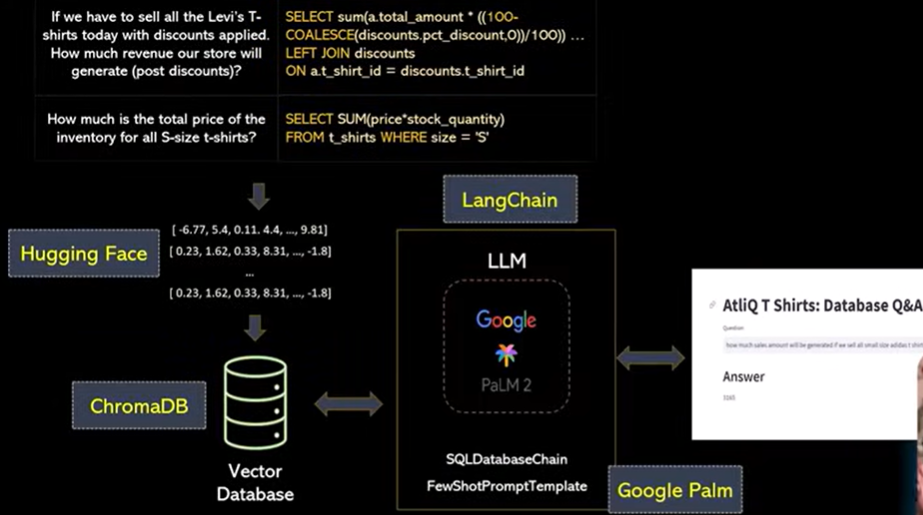

In [24]:
qns1

'83'

In [25]:
few_shots = [
    {'Question' : "How many t-shirts do we have left for Nike in XS size and white color?",
     'SQLQuery' : "SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Nike' AND color = 'White' AND size = 'XS'",
     'SQLResult': "Result of the SQL query",
     'Answer' : qns1},
    {'Question': "How much is the total price of the inventory for all S-size t-shirts?",
     'SQLQuery':"SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'",
     'SQLResult': "Result of the SQL query",
     'Answer': qns2},
    {'Question': "If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?" ,
     'SQLQuery' : """SELECT sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from (select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'
group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
 """,
     'SQLResult': "Result of the SQL query",
     'Answer': qns3} ,
     {'Question' : "If we have to sell all the Levi’s T-shirts today. How much revenue our store will generate without discount?" ,
      'SQLQuery': "SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'",
      'SQLResult': "Result of the SQL query",
      'Answer' : qns4},
    {'Question': "How many white color Levi's shirt I have?",
     'SQLQuery' : "SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'",
     'SQLResult': "Result of the SQL query",
     'Answer' : qns5
     }
]

In [26]:
type(few_shots)

list

Creating Semantic Similarity Based example selector
- create embedding on the few_shots
- Store the embeddings in Chroma DB
- Retrieve the the top most Semantically close example from the vector store

In [27]:
from langchain.prompts import SemanticSimilarityExampleSelector
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma


embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')


In [28]:
to_vectorize = [" ".join(example.values()) for example in few_shots]

In [29]:
for example in few_shots:
    print(example)
    print([type(value) for value in example.values()])


{'Question': 'How many t-shirts do we have left for Nike in XS size and white color?', 'SQLQuery': "SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Nike' AND color = 'White' AND size = 'XS'", 'SQLResult': 'Result of the SQL query', 'Answer': '83'}
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]
{'Question': 'How much is the total price of the inventory for all S-size t-shirts?', 'SQLQuery': "SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'", 'SQLResult': 'Result of the SQL query', 'Answer': '20617'}
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]
{'Question': 'If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?', 'SQLQuery': "SELECT sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from (select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'\ngroup by t_shirt_id) a left join discoun

In [30]:
to_vectorize

["How many t-shirts do we have left for Nike in XS size and white color? SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Nike' AND color = 'White' AND size = 'XS' Result of the SQL query 83",
 "How much is the total price of the inventory for all S-size t-shirts? SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S' Result of the SQL query 20617",
 "If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)? SELECT sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from (select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'\ngroup by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id\n  Result of the SQL query 16654.8",
 "If we have to sell all the Levi’s T-shirts today. How much revenue our store will generate without discount? SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi' R

In [31]:
vectorstore = Chroma.from_texts(to_vectorize, embeddings, metadatas=few_shots)


In [35]:
total_items = 5  # Replace this with the actual number of items

# Iterate over each item index
for i in range(total_items):
    try:
        item = vectorstore.get_item(i)
        text = item.text
        embedding = item.embedding
        metadata = item.metadata

        # Print the text and its corresponding embedding
        print("Text:", text)
        print("Embedding:", embedding)
        print("Metadata:", metadata)  # Metadata could be None if not provided
        print("-------------------------------------")
    except IndexError:
        print("Index out of range")
        break

AttributeError: 'Chroma' object has no attribute 'get_item'

In [36]:
example_selector = SemanticSimilarityExampleSelector(
    vectorstore=vectorstore,
    k=5,
)

example_selector.select_examples({"Question": "How many Adidas T shirts I have left in my store?"})

[{'Answer': '83',
  'Question': 'How many t-shirts do we have left for Nike in XS size and white color?',
  'SQLQuery': "SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Nike' AND color = 'White' AND size = 'XS'",
  'SQLResult': 'Result of the SQL query'},
 {'Answer': '16879',
  'Question': 'If we have to sell all the Levi’s T-shirts today. How much revenue our store will generate without discount?',
  'SQLQuery': "SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'",
  'SQLResult': 'Result of the SQL query'},
 {'Answer': '192',
  'Question': "How many white color Levi's shirt I have?",
  'SQLQuery': "SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'",
  'SQLResult': 'Result of the SQL query'},
 {'Answer': '20617',
  'Question': 'How much is the total price of the inventory for all S-size t-shirts?',
  'SQLQuery': "SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'",
  'SQLResult': 'Result of the SQL query'},
 {'Answ

In [44]:
from langchain.prompts import FewShotPromptTemplate
from langchain.chains.sql_database.prompt import PROMPT_SUFFIX, _mysql_prompt

In [46]:
print(_mysql_prompt)

You are a MySQL expert. Given an input question, first create a syntactically correct MySQL query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per MySQL. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use CURDATE() function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result of

In [47]:
mysql_prompt = """You are a MySQL expert. Given an input question, first create a syntactically correct MySQL query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per MySQL. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use CURDATE() function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result of the SQLQuery
Answer: Final answer here"""

In [45]:
print(PROMPT_SUFFIX)

Only use the following tables:
{table_info}

Question: {input}


In [48]:
from langchain.prompts.prompt import PromptTemplate

example_prompt = PromptTemplate(
    input_variables=["Question", "SQLQuery", "SQLResult","Answer",],
    template="\nQuestion: {Question}\nSQLQuery: {SQLQuery}\nSQLResult: {SQLResult}\nAnswer: {Answer}",
)